In [1]:
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/tshen/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timid_animals = set([18, 13, 8, 25, 21, 9, 4, 2, 15])
intermediate_animals = set([10, 11, 24, 17, 1, 6])
confident_animals = set([5, 16, 20, 12, 19, 0, 22, 23, 14, 3, 7])

In [ ]:
# For each animal, there is an empirical posterior distribution which contains the parameters "theta", statistics "x", the recovery-target "gt" which is a repeat of the data in gt_stats dict, distance of stats "x" to the recovery-target "distances" and the raw simulations "simulations".
# Note that smc_data[animal][key] is num_populations x num_particles_in_posterior_of_population x dimension of key (e.g. 9 for "theta")

In [3]:
with open('./recovery/SMC_fits.json', 'r') as f:
    smc_data = json.load(f)

In [4]:
with open('../out/recovery/abcsmc_best_samples.json', 'r') as f:
    gt_stats = json.load(f)

In [5]:
# normalize by the recovery-target means and stds
gt_mu = np.array([v for k, v in gt_stats['theta'].items()]).mean(axis=0)
gt_std = np.array([v for k, v in gt_stats['theta'].items()]).std(axis=0)

In [20]:
# this takes an animal_num as input, and plots the posterior distribution at population_num as well as the recovery-target; also prints closest particle (theta space) in population_num
def recovery_plot(k, population_num=-1, save_fig=False):
    param_names = [r'$nCVaR_\alpha$', r'$G_0$', r'$f$ Forget-rate', 
            r'$\theta_2$ mean', r'$\theta_3$ mean', r'$\theta_4$ mean', 
            r'$\theta_2$ normalized dev', r'$\theta_3$ normalized dev', r'$\theta_4$ normalized dev']

    posterior = np.array(smc_data[str(k)]["theta"][population_num])
    gt = np.array(gt_stats["theta"][str(k)])

    mu = posterior.mean(axis=0)
    std = posterior.std(axis=0)
    posterior_normed = (posterior - gt_mu)/gt_std
    gt_normed = (gt - gt_mu)/gt_std

    distances = np.abs(posterior_normed - gt_normed).mean(axis=1)
    idxs = np.argsort(distances)

    print("Animal {}, closest distance: {}\nGT particle: {}\nClosest particle: {}".format(k, distances[idxs[0]], np.around(gt, 3), np.around(posterior[idxs[0]], 3)))
    analysis.pairplot(posterior, points=[gt, mu], labels=param_names, diag="hist", offdiag="kde2d",
                      title="Marginal and pairwise posterior distributions for animal {}".format(k+1),
                      points_offdiag={
                            "marker": ".",
                            "markersize": 8,
                        },
                      limits=[[0.6, 1.0], [0, 40], [0.05, 0.2], 
                              [0.0, 0.4], [0.0, 0.4], [0.0, 1.0], 
                              [0.3, 1.0], [0.4, 1.0], [0.0, 1.0]], points_colors=['#4F7942', '#FF5733'])
    
    if save_fig:
        plt.savefig("../out/temp2.png", dpi=600, bbox_inches='tight', transparent=True)

    return [gt, mu]

# takes an animal_num as input, and prints 2 things: 1) the closest particle by normalized theta distance and 2) closest particle by stats then theta distance
def closest_particle(k):
    posterior = np.vstack([np.array(x) for x in smc_data[str(k)]["theta"]])
    ds = np.concatenate([np.array(x) for x in smc_data[str(k)]["distances"]])
    stats = np.concatenate([np.array(x) for x in smc_data[str(k)]["x"]])
    gt = np.array(gt_stats["theta"][str(k)])

    # mu = posterior.mean(axis=0)
    # std = posterior.std(axis=0)
    posterior_normed = (posterior - gt_mu)/gt_std
    gt_normed = (gt - gt_mu)/gt_std

    distances = np.abs(posterior_normed - gt_normed).mean(axis=1)
    idxs = np.argsort(distances)

    # closest by theta distance
    print("\nAnimal {}, closest theta distance: {:.2f}, its x distance: {:.2f}\nGT particle: {}\nClosest particle: {}\nGT stats: {}\nClosest particle stats: {}".format(
        k, distances[idxs[0]], ds[idxs[0]], np.around(gt, 3), np.around(posterior[idxs[0]], 3), np.array(gt_stats["x"][str(k)]), stats[idxs[0]]))

    min_loss_idxs = np.where(ds == ds.min())[0]
    idx = min_loss_idxs[distances[min_loss_idxs].argmin()]

    # closest by SMC loss then theta distance
    print("\nAnimal {}, closest x distance: {:.2f}, its theta distance: {:.2f}\nGT particle: {}\nClosest particle: {}\nGT stats: {}\nClosest particle stats: {}".format(
        k, ds[idx], distances[idx], np.around(gt, 3), np.around(posterior[idx], 3), np.array(gt_stats["x"][str(k)]), stats[idx]))

    return [[distances[idxs[0]], ds[idxs[0]], ds[idx], distances[idx]], posterior[idxs[0]], posterior[idx], gt]

In [7]:
parameter_keys = ["cvar", "G", "fr", "mu1", "mu2", "mu3", "u1", "u2", "u3"]

In [8]:
theta_dists = []
x_dists = []
theta_close_values = {k: [] for k in parameter_keys}
x_close_values = {k: [] for k in parameter_keys}
gt_values = {k: [] for k in parameter_keys}
animal_nums = []
groups = []

In [9]:
for k in sorted(list(timid_animals)):
    (theta_close_theta_d, theta_close_x_d, x_close_x_d, x_close_theta_d), theta_close, x_close, gt_arr = closest_particle(k)
    theta_dists.append(theta_close_theta_d)
    x_dists.append(x_close_x_d)

    animal_nums.append(k)
    groups.append("timid")

    for i, j in enumerate(parameter_keys):
        gt_values[j].append(gt_arr[i])
        theta_close_values[j].append(theta_close[i])
        x_close_values[j].append(x_close[i])


Animal 2, closest theta distance: 0.21, its x distance: 0.02
GT particle: [ 0.548 54.669  0.169  0.232  0.881  0.338  0.332  0.255  0.648]
Closest particle: [ 0.611 52.721  0.176  0.245  0.955  0.314  0.267  0.313  0.577]
GT stats: [67.          1.94117647  2.          0.52994171]
Closest particle stats: [68.          2.          2.          0.53271028]

Animal 2, closest x distance: 0.00, its theta distance: 0.39
GT particle: [ 0.548 54.669  0.169  0.232  0.881  0.338  0.332  0.255  0.648]
Closest particle: [ 0.523 58.105  0.174  0.211  0.662  0.123  0.284  0.281  0.87 ]
GT stats: [67.          1.94117647  2.          0.52994171]
Closest particle stats: [67.          1.94117647  2.          0.52994171]

Animal 4, closest theta distance: 0.27, its x distance: 0.00
GT particle: [7.6200e-01 4.9507e+01 1.1900e-01 2.6100e-01 2.8000e-01 4.9200e-01
 1.0000e-02 7.9800e-01 2.7800e-01]
Closest particle: [ 0.691 54.88   0.114  0.265  0.399  0.497  0.134  0.687  0.269]
GT stats: [48.          2.

In [10]:
for k in sorted(list(intermediate_animals)):
    (theta_close_theta_d, theta_close_x_d, x_close_x_d, x_close_theta_d), theta_close, x_close, gt_arr = closest_particle(k)
    theta_dists.append(theta_close_theta_d)
    x_dists.append(x_close_x_d)

    animal_nums.append(k)
    groups.append("intermediate")

    for i, j in enumerate(parameter_keys):
        theta_close_values[j].append(theta_close[i])
        x_close_values[j].append(x_close[i])
        gt_values[j].append(gt_arr[i])


Animal 1, closest theta distance: 0.15, its x distance: 0.03
GT particle: [ 0.752 34.169  0.287  0.127  0.218  0.873  0.595  0.427  0.115]
Closest particle: [ 0.778 32.462  0.292  0.191  0.211  0.908  0.591  0.464  0.099]
GT stats: [ 3.20000000e+01 -1.00000000e+03  2.57142857e+00  2.94117647e+00
  9.06183369e-01]
Closest particle stats: [ 3.30000000e+01 -1.00000000e+03  2.71428571e+00  3.00000000e+00
  9.28571429e-01]

Animal 1, closest x distance: 0.00, its theta distance: 0.30
GT particle: [ 0.752 34.169  0.287  0.127  0.218  0.873  0.595  0.427  0.115]
Closest particle: [ 0.684 32.724  0.296  0.125  0.195  0.549  0.643  0.491  0.154]
GT stats: [ 3.20000000e+01 -1.00000000e+03  2.57142857e+00  2.94117647e+00
  9.06183369e-01]
Closest particle stats: [ 3.20000000e+01 -1.00000000e+03  2.57142857e+00  2.94117647e+00
  9.06183369e-01]

Animal 6, closest theta distance: 0.53, its x distance: 0.28
GT particle: [ 0.59  18.605  0.221  0.267  0.187  0.254  0.626  0.235  0.397]
Closest partic

In [11]:
for k in sorted(list(confident_animals)):
    (theta_close_theta_d, theta_close_x_d, x_close_x_d, x_close_theta_d), theta_close, x_close, gt_arr = closest_particle(k)
    theta_dists.append(theta_close_theta_d)
    x_dists.append(x_close_x_d)

    animal_nums.append(k)
    groups.append("brave")

    for i, j in enumerate(parameter_keys):
        theta_close_values[j].append(theta_close[i])
        x_close_values[j].append(x_close[i])
        gt_values[j].append(gt_arr[i])


Animal 0, closest theta distance: 0.16, its x distance: 0.10
GT particle: [ 0.84  15.832  0.144  0.311  0.318  0.25   0.798  0.732  0.854]
Closest particle: [ 0.822 16.245  0.137  0.311  0.119  0.215  0.789  0.72   0.898]
GT stats: [24.         48.          2.8         4.          4.          0.58823529]
Closest particle stats: [24.         48.          4.          4.          4.          0.60150376]

Animal 0, closest x distance: 0.01, its theta distance: 0.39
GT particle: [ 0.84  15.832  0.144  0.311  0.318  0.25   0.798  0.732  0.854]
Closest particle: [ 0.826 18.443  0.137  0.106  0.309  0.169  0.843  0.582  0.826]
GT stats: [24.         48.          2.8         4.          4.          0.58823529]
Closest particle stats: [24.         48.          2.8         4.          4.          0.55147059]

Animal 3, closest theta distance: 0.23, its x distance: 0.01
GT particle: [ 0.457 35.129  0.165  0.115  0.286  0.366  0.688  0.524  0.737]
Closest particle: [ 0.44  36.245  0.173  0.093  0.

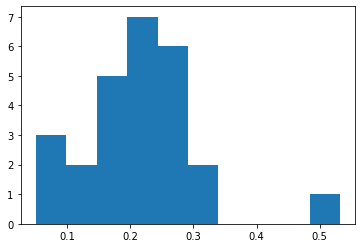

In [12]:
plt.hist(theta_dists);

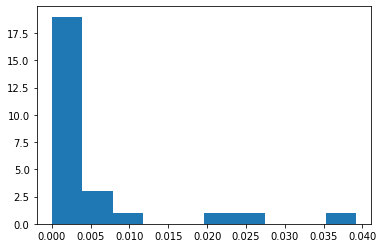

In [13]:
plt.hist(x_dists);

In [14]:
mean_values = {k: [] for k in parameter_keys}

Animal 2, closest distance: 0.3865753398528536
GT particle: [ 0.548 54.669  0.169  0.232  0.881  0.338  0.332  0.255  0.648]
Closest particle: [ 0.597 54.091  0.173  0.224  0.636  0.333  0.242  0.402  0.913]
Animal 4, closest distance: 0.3412811276518556
GT particle: [7.6200e-01 4.9507e+01 1.1900e-01 2.6100e-01 2.8000e-01 4.9200e-01
 1.0000e-02 7.9800e-01 2.7800e-01]
Closest particle: [ 0.856 40.686  0.11   0.266  0.344  0.41   0.105  0.847  0.424]
Animal 8, closest distance: 0.48001391239371105
GT particle: [ 0.453 51.283  0.274  0.148  0.398  0.468  0.104  0.221  0.655]
Closest particle: [ 0.697 44.881  0.262  0.282  0.394  0.561  0.179  0.26   0.679]
Animal 9, closest distance: 0.32300435581147874
GT particle: [ 0.694 40.623  0.176  0.267  0.635  0.747  0.208  0.315  0.207]
Closest particle: [ 0.698 36.084  0.184  0.242  0.756  0.668  0.143  0.442  0.377]
Animal 13, closest distance: 0.5212950151363328
GT particle: [0.561 7.672 0.158 0.236 0.871 0.642 0.373 0.408 0.939]
Closest part

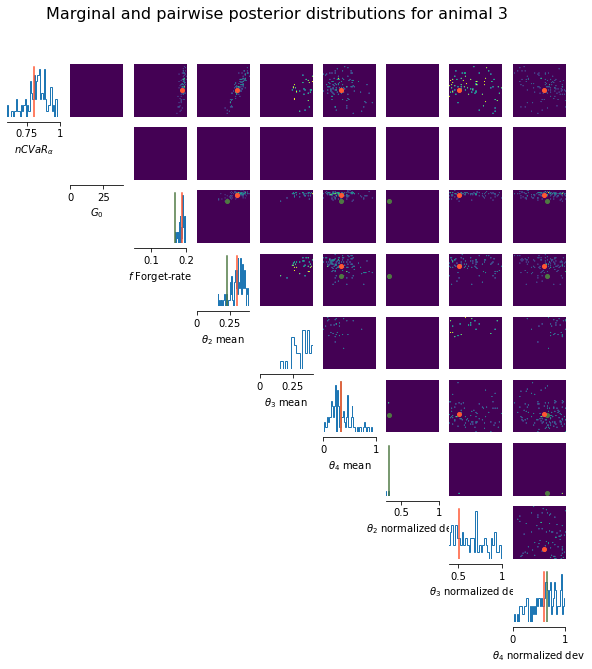

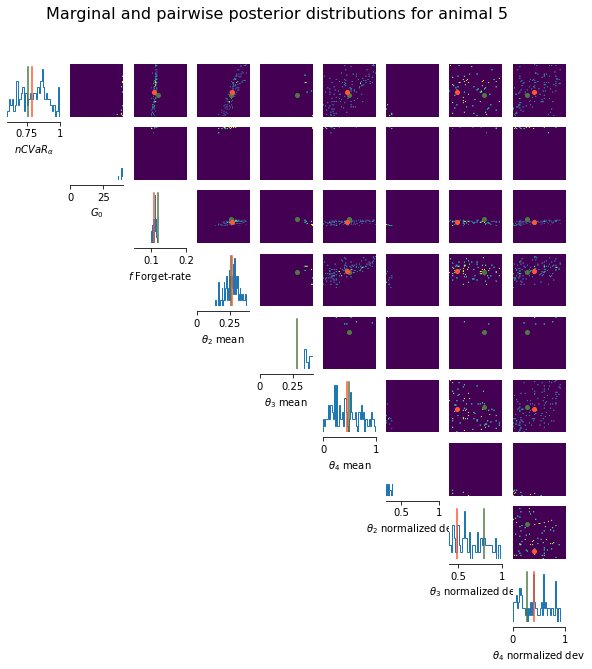

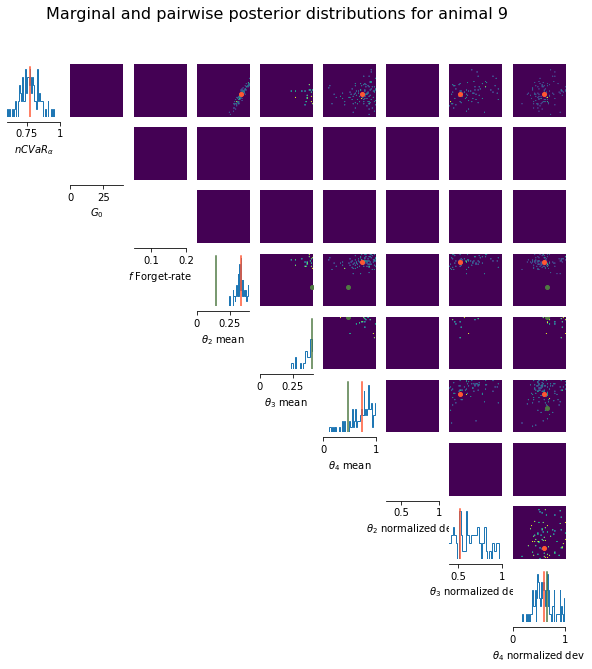

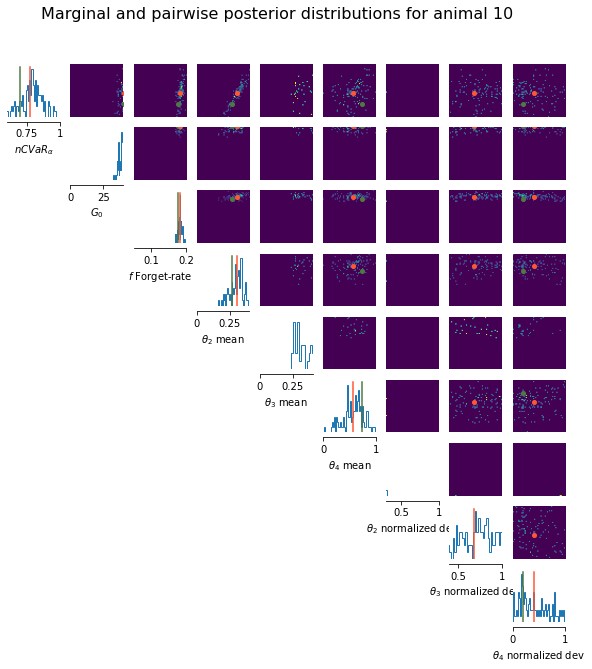

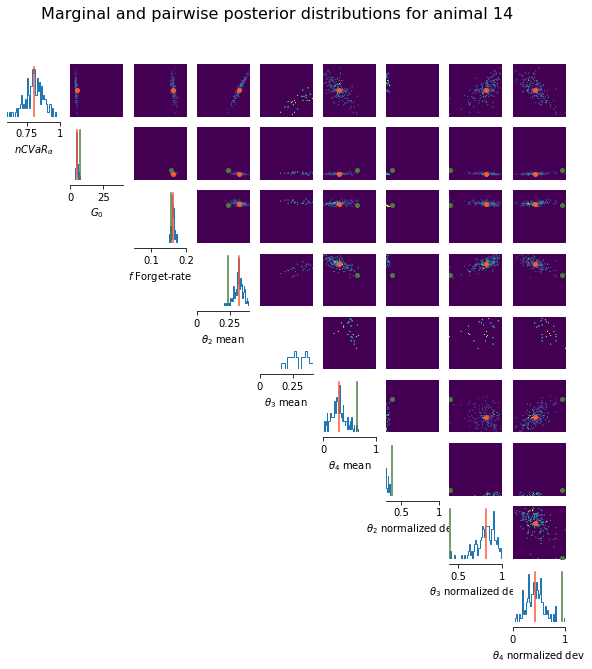

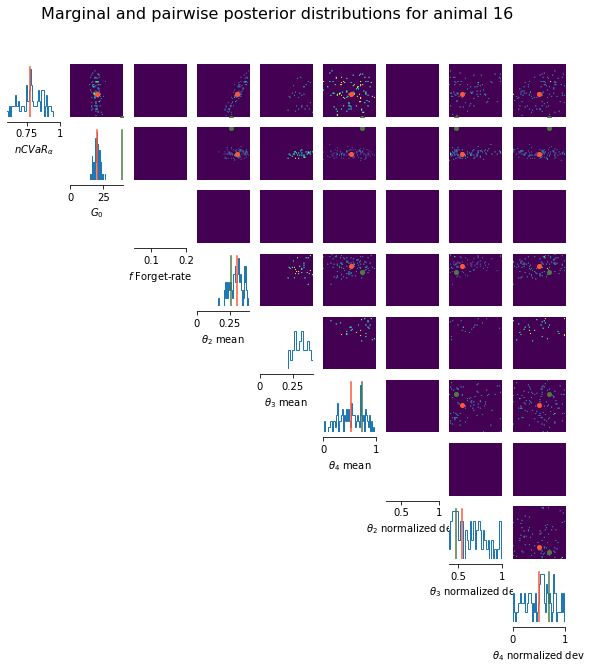

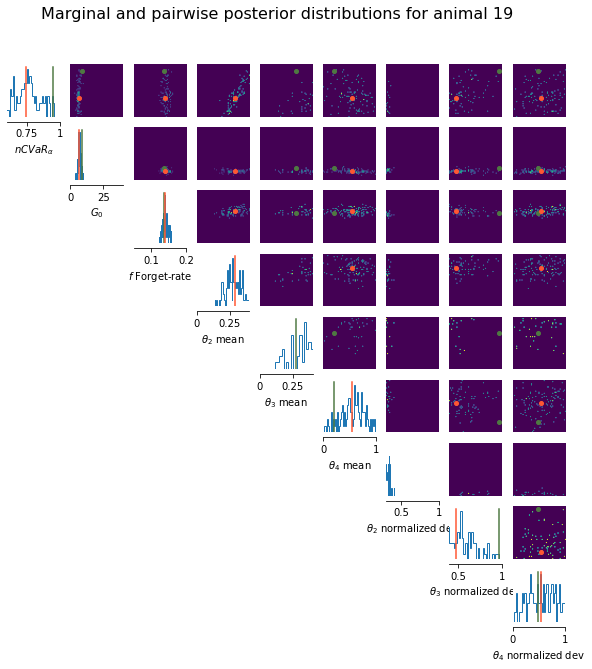

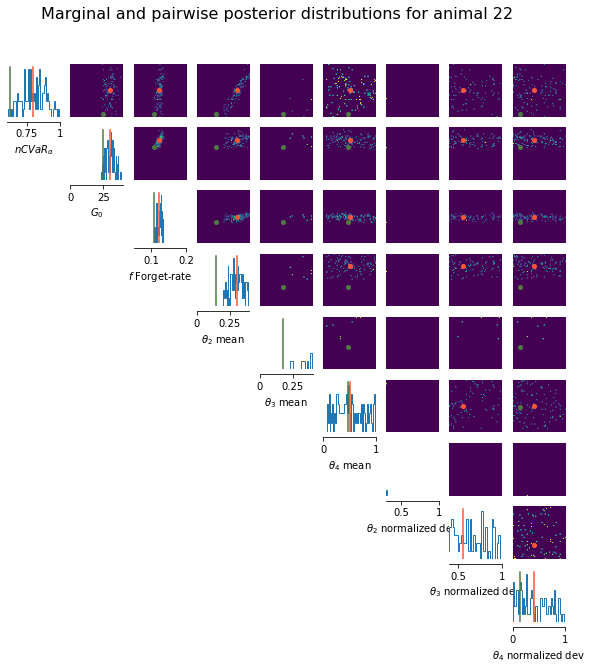

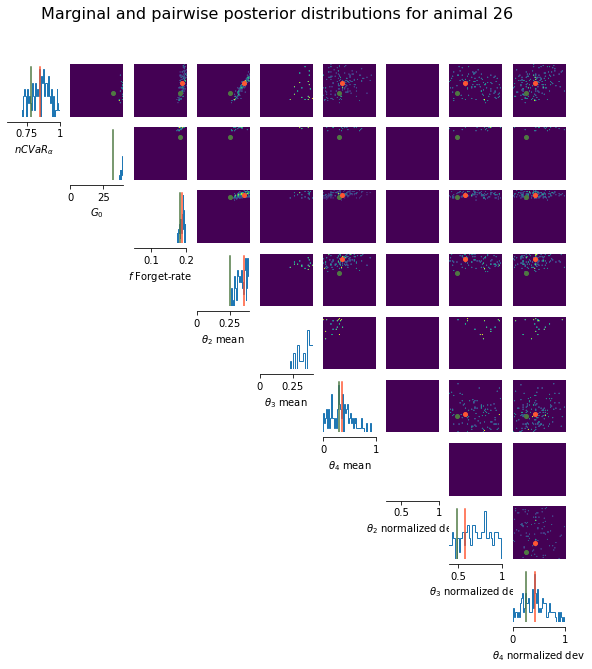

In [24]:
for k in sorted(list(timid_animals)):
    gt_arr, mean_arr = recovery_plot(k)

    for i, j in enumerate(parameter_keys):
        mean_values[j].append(mean_arr[i])

Animal 1, closest distance: 0.4736812324495634
GT particle: [ 0.752 34.169  0.287  0.127  0.218  0.873  0.595  0.427  0.115]
Closest particle: [ 0.825 50.892  0.282  0.198  0.076  0.869  0.577  0.726  0.119]


Animal 6, closest distance: 0.6415568610935403
GT particle: [ 0.59  18.605  0.221  0.267  0.187  0.254  0.626  0.235  0.397]
Closest particle: [ 0.587 41.959  0.27   0.242  0.493  0.207  0.504  0.448  0.499]
Animal 10, closest distance: 0.3825261637810448
GT particle: [ 0.698 65.445  0.197  0.227  0.135  0.785  0.492  0.376  0.17 ]
Closest particle: [6.1600e-01 6.6596e+01 2.7900e-01 2.4000e-01 1.0600e-01 8.1500e-01
 5.7400e-01 4.6300e-01 6.1000e-02]
Animal 11, closest distance: 0.6604473958255483
GT particle: [ 0.859 13.424  0.212  0.412  0.687  0.666  0.612  0.224  0.447]
Closest particle: [ 0.845 18.461  0.335  0.323  0.51   0.392  0.435  0.177  0.45 ]
Animal 17, closest distance: 0.22347290140511145
GT particle: [ 0.92  46.43   0.274  0.363  0.273  0.577  0.63   0.289  0.091]
Closest particle: [ 0.856 46.075  0.285  0.321  0.165  0.675  0.61   0.298  0.108]
Animal 24, closest distance: 0.5458464197839175
GT particle: [ 0.584 26.964  0.101  0.083  0.163  0.507  0.454  0.168  0.766]
C

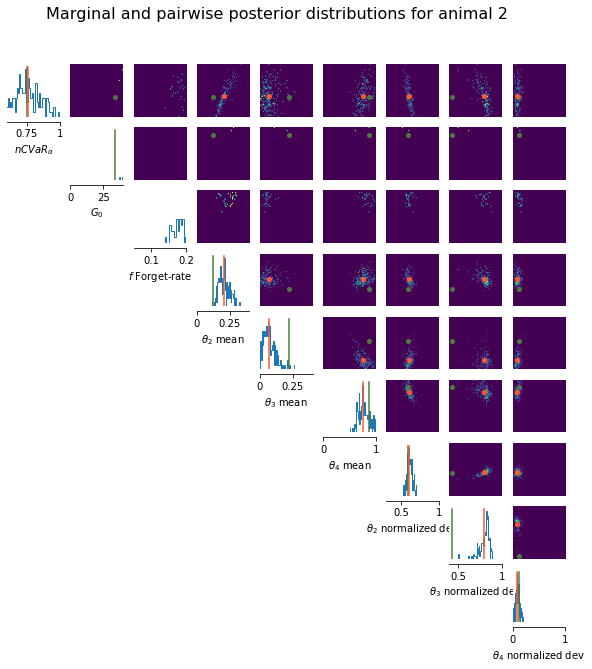

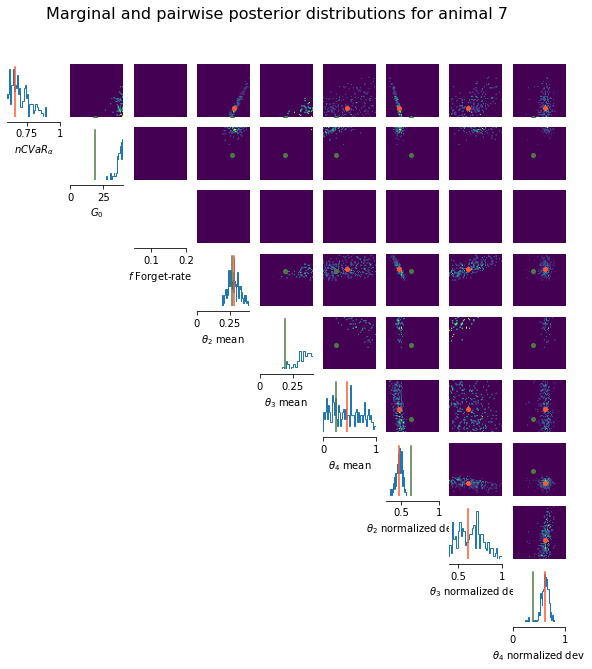

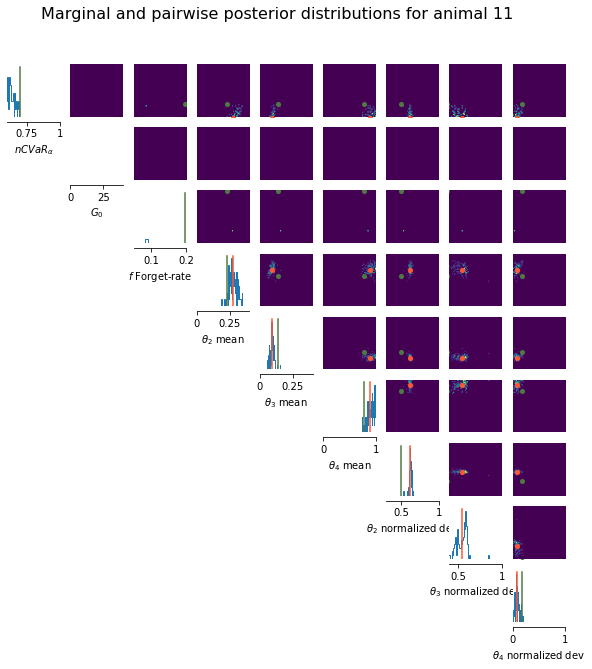

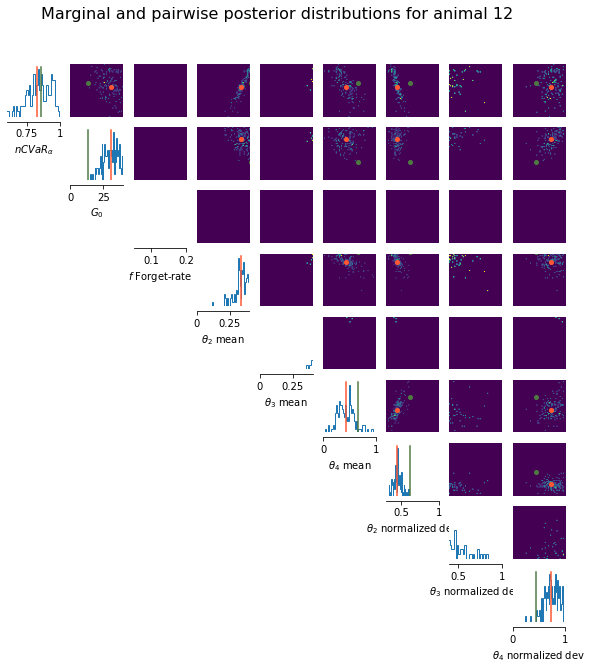

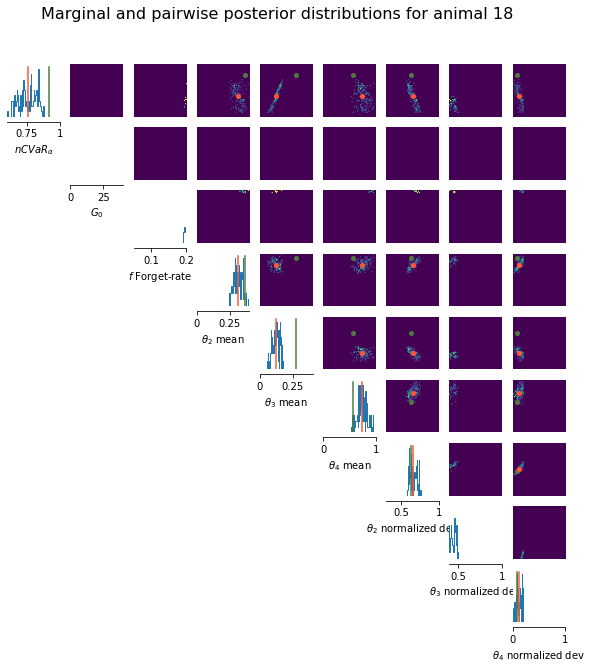

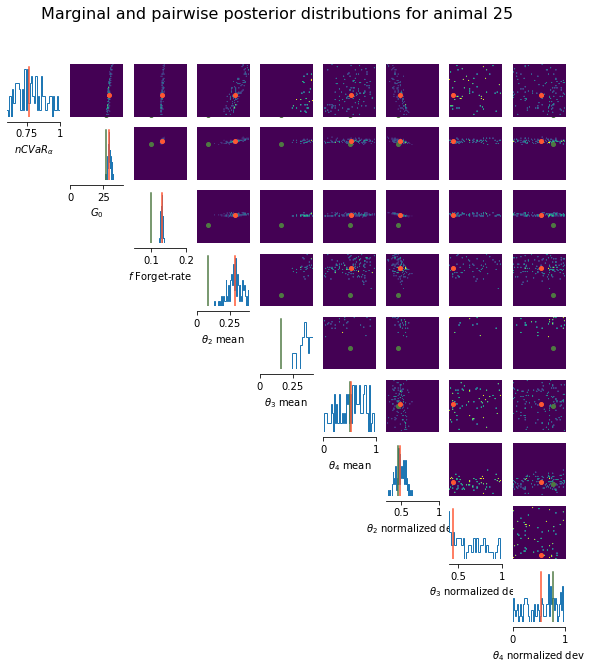

In [25]:
for k in sorted(list(intermediate_animals)):
    gt_arr, mean_arr = recovery_plot(k)
    
    for i, j in enumerate(parameter_keys):
        mean_values[j].append(mean_arr[i])

Animal 23, closest distance: 0.399703942946805
GT particle: [ 0.859 20.128  0.177  0.1    0.358  0.774  0.347  0.878  0.303]
Closest particle: [ 0.767 18.188  0.167  0.109  0.309  0.665  0.583  0.967  0.507]


[array([ 0.85864103, 20.12776265,  0.17742021,  0.09992205,  0.35808664,
         0.77351769,  0.34683312,  0.87808932,  0.30286406]),
 array([ 0.71518947, 17.98149071,  0.16761646,  0.18383014,  0.19810252,
         0.54111471,  0.73187541,  0.88628228,  0.48597426])]

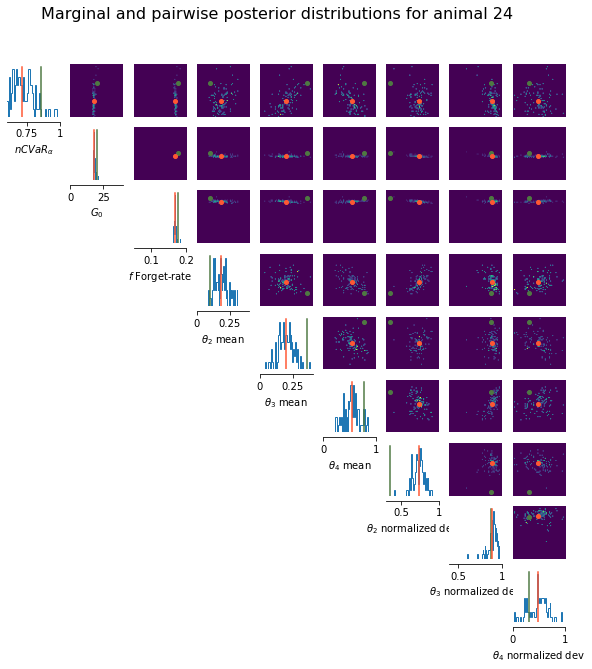

In [26]:
recovery_plot(sorted(list(confident_animals))[-1], save_fig=True)

Animal 0, closest distance: 0.4716755507970951
GT particle: [ 0.84  15.832  0.144  0.311  0.318  0.25   0.798  0.732  0.854]
Closest particle: [ 0.725 17.524  0.145  0.17   0.273  0.1    0.871  0.651  0.665]
Animal 3, closest distance: 0.5023665841248975
GT particle: [ 0.457 35.129  0.165  0.115  0.286  0.366  0.688  0.524  0.737]
Closest particle: [ 0.568 36.072  0.161  0.242  0.561  0.513  0.772  0.604  0.691]
Animal 5, closest distance: 0.31097708033540905
GT particle: [ 0.901 16.328  0.151  0.072  0.366  0.281  0.566  0.68   0.863]
Closest particle: [ 0.922 17.062  0.152  0.231  0.384  0.26   0.648  0.754  0.755]
Animal 7, closest distance: 0.05034713527781302
GT particle: [ 0.804 15.775  0.151  0.327  0.321  0.221  0.84   0.709  0.826]
Closest particle: [ 0.81  15.919  0.152  0.355  0.304  0.225  0.829  0.711  0.822]
Animal 12, closest distance: 0.19654326081363233
GT particle: [ 0.923 17.628  0.133  0.115  0.118  0.211  0.634  0.611  0.511]
Closest particle: [ 0.913 16.866  0.132

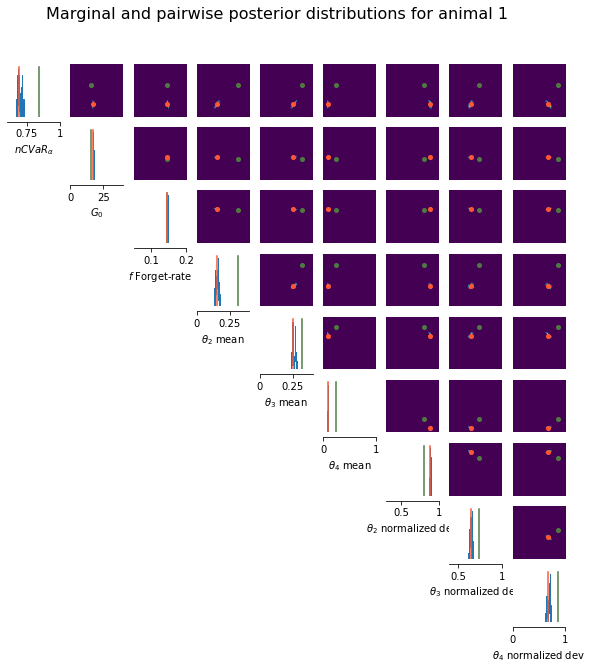

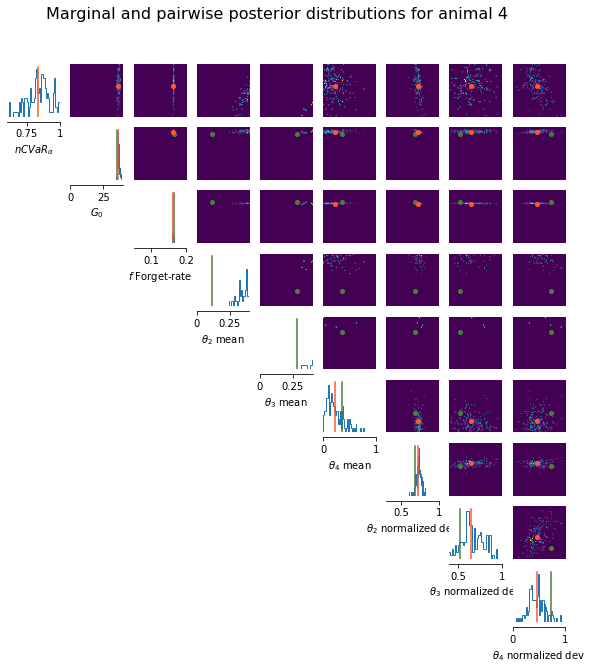

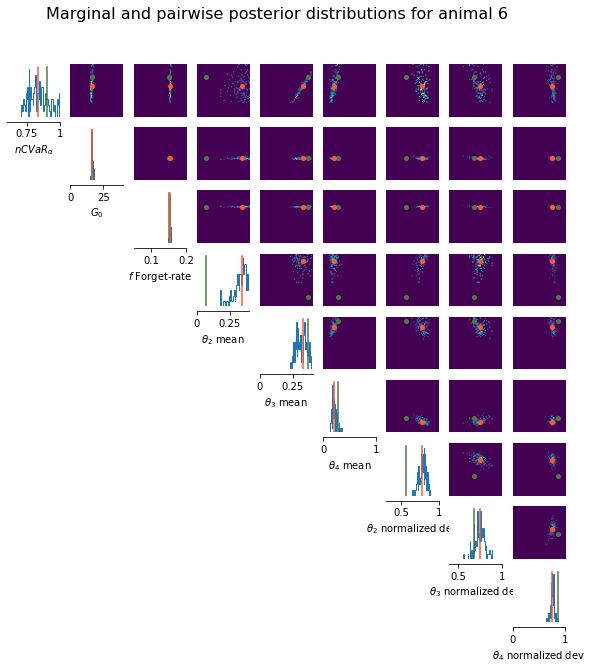

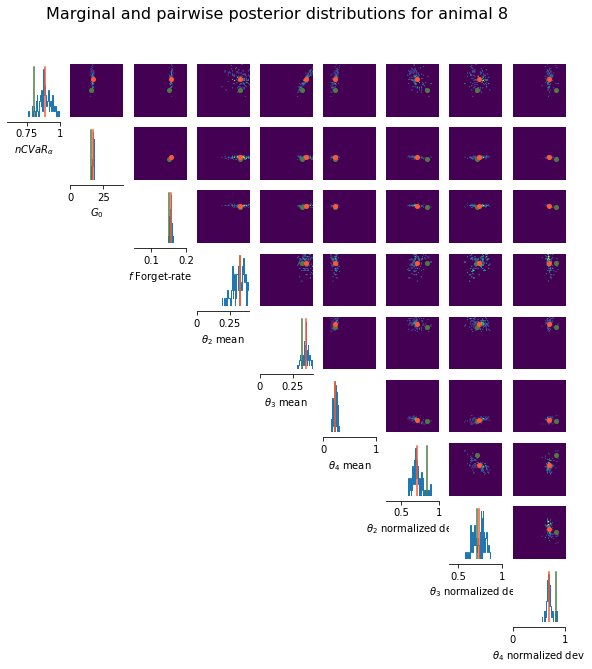

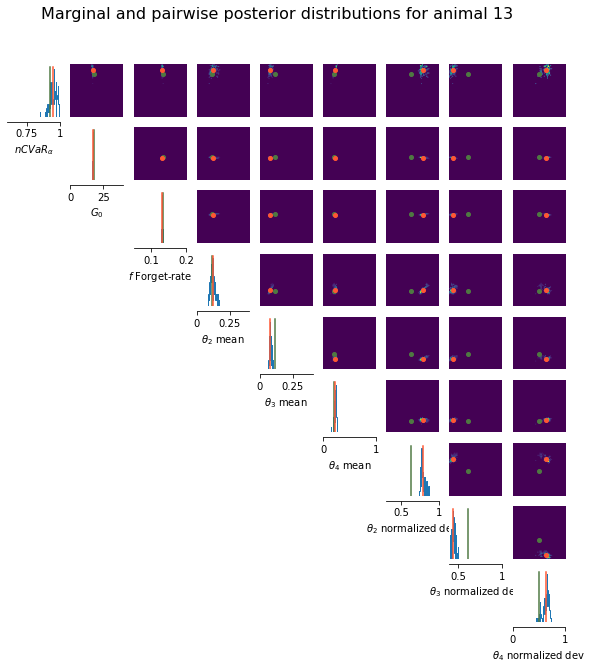

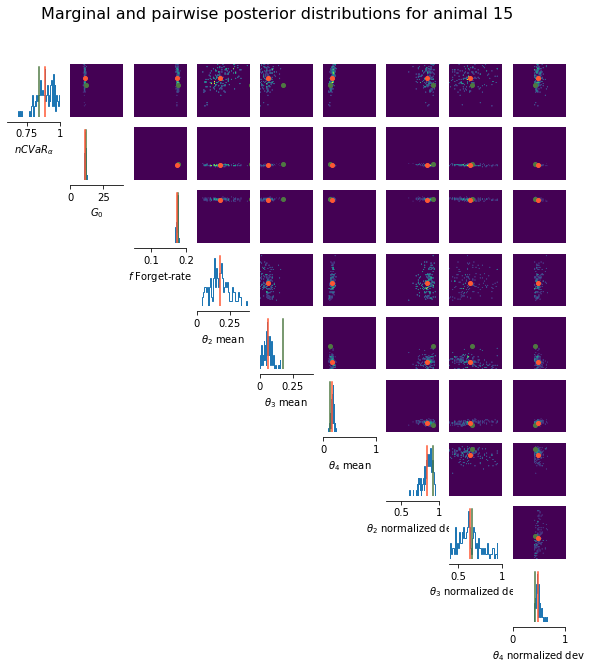

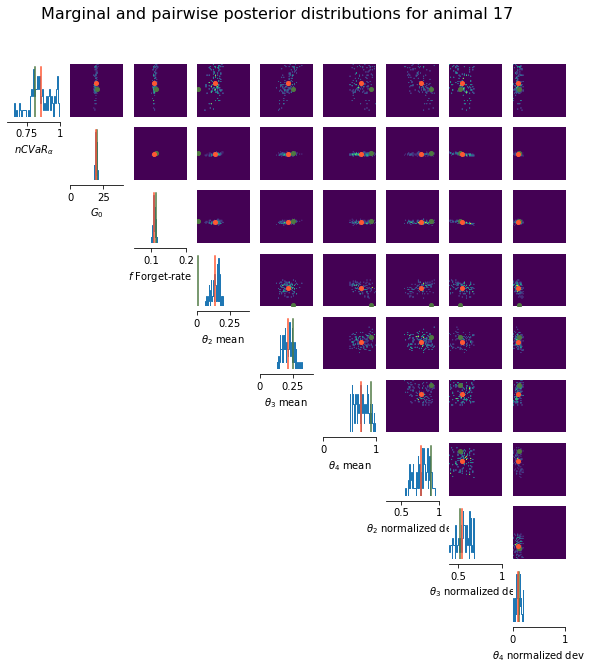

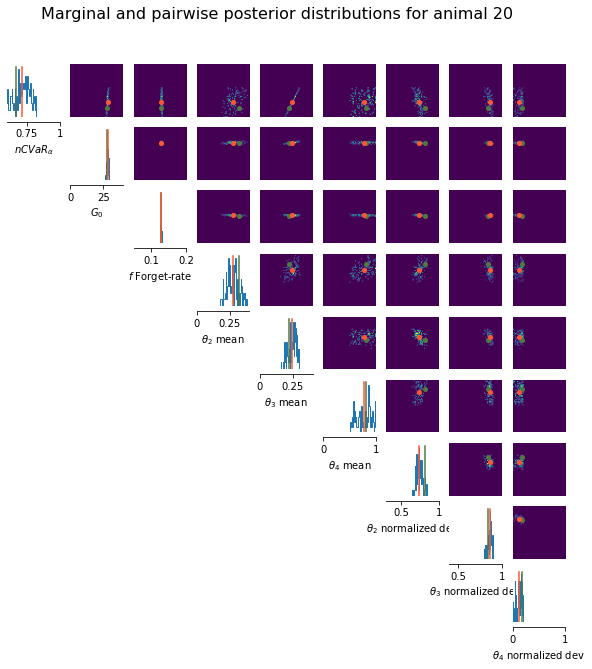

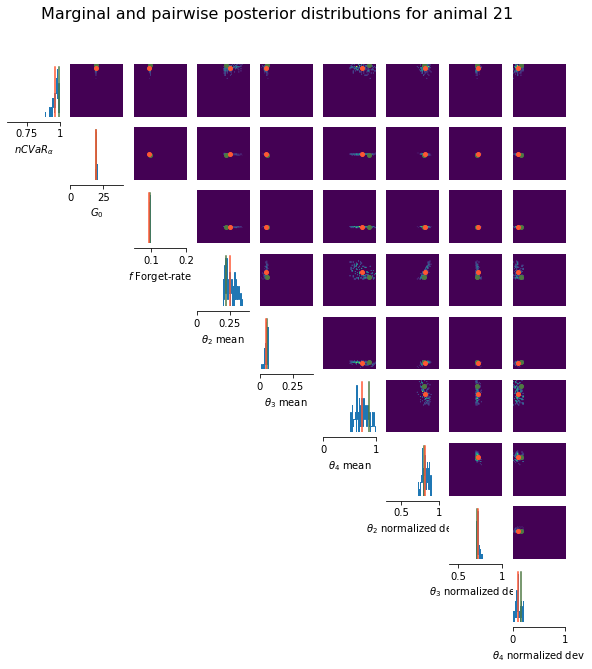

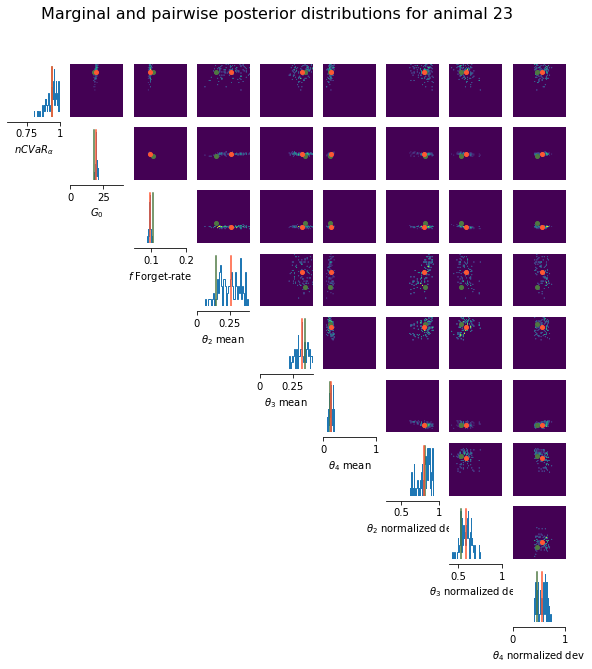

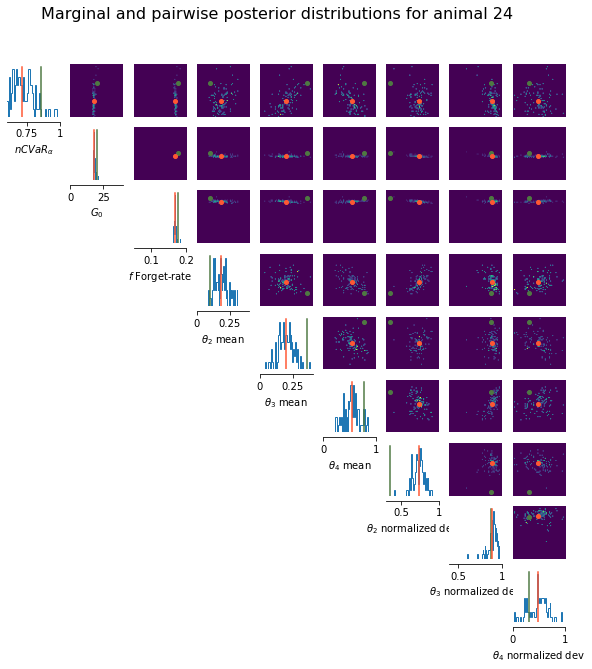

In [27]:
for k in sorted(list(confident_animals)):
    gt_arr, mean_arr = recovery_plot(k)

    for i, j in enumerate(parameter_keys):
        mean_values[j].append(mean_arr[i])

In [58]:
from sklearn.metrics import r2_score

def plot_gt_fit_each_dim(gt_vals, fit_vals, ylabel, outfile="../out/temp1.png"):

    timid_color = "#FF715B"
    inter_color = "#4C5454"
    brave_color = "#1EA896"
    color_dict={"timid": timid_color, "intermediate": inter_color, "brave": brave_color}

    figsize = (3*6, 3*6)

    axlabelsize = 20
    axticklabelsize = 18
    titlesize = 24
    dot_size = 64
    line_thickness = 2
    vert_dist_btw_subplots = 0.3

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=figsize)

    titles = [r'$nCVaR_\alpha$', r'$G_0$', r'$f$ Forget-rate', 
              r'$\theta_2$ mean', r'$\theta_3$ mean', r'$\theta_4$ mean', 
              r'$\theta_2$ normalized deviation', r'$\theta_3$ normalized deviation', r'$\theta_4$ normalized deviation']

    for n, k in enumerate(parameter_keys):

        j = n % 3
        i = n // 3

        x, y = gt_vals[k], fit_vals[k]
        axes[i, j].scatter(x, y, s=dot_size, c=[color_dict[g] for g in groups])  # 'viridis' is just an example colormap
        axes[i, j].set_title(titles[n], fontsize=titlesize)

        if n == 0:
            axes[i, j].scatter([],[], marker="o", color=timid_color, label="timid")
            axes[i, j].scatter([],[], marker="o", color=inter_color, label="inter")
            axes[i, j].scatter([],[], marker="o", color=brave_color, label="brave")

            axes[i, j].legend(loc='lower right', fontsize=axlabelsize)
            axes[i, j].set_xlabel('Recovery target', fontsize=axlabelsize)
            axes[i, j].set_ylabel(ylabel, fontsize=axlabelsize)

        axes[i, j].tick_params(axis='both', which='both', labelsize=axticklabelsize)

        x_line = np.linspace(min(x), max(x), 100)  # Adjust the range if needed
        axes[i, j].plot(x_line, x_line, linewidth=line_thickness, linestyle='--', color='gray', label='y=x')

        r2 = r2_score(x, y)
        annotation_x = axes[i, j].get_xlim()[0] + 0.09 * (axes[i, j].get_xlim()[1] - axes[i, j].get_xlim()[0])
        annotation_y = axes[i, j].get_ylim()[1] - 0.13 * (axes[i, j].get_ylim()[1] - axes[i, j].get_ylim()[0])
        axes[i, j].annotate(r"$R^2$ = {:.2f}".format(r2), (annotation_x, annotation_y), fontsize=axticklabelsize)

    plt.subplots_adjust(hspace=vert_dist_btw_subplots)
    fig.savefig(outfile, dpi=600, bbox_inches='tight', transparent=True)

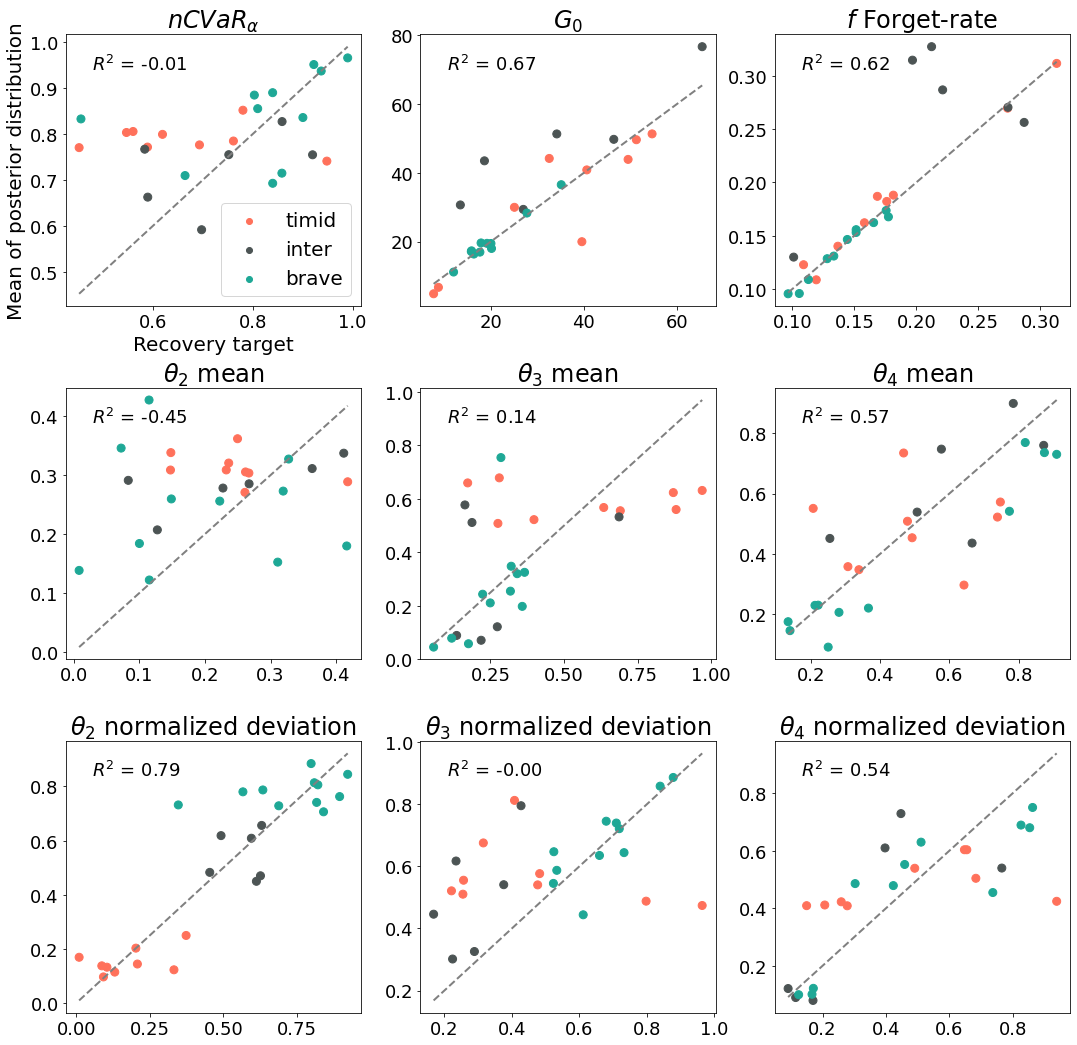

In [59]:
plot_gt_fit_each_dim(gt_values, mean_values, ylabel="Mean of posterior distribution")

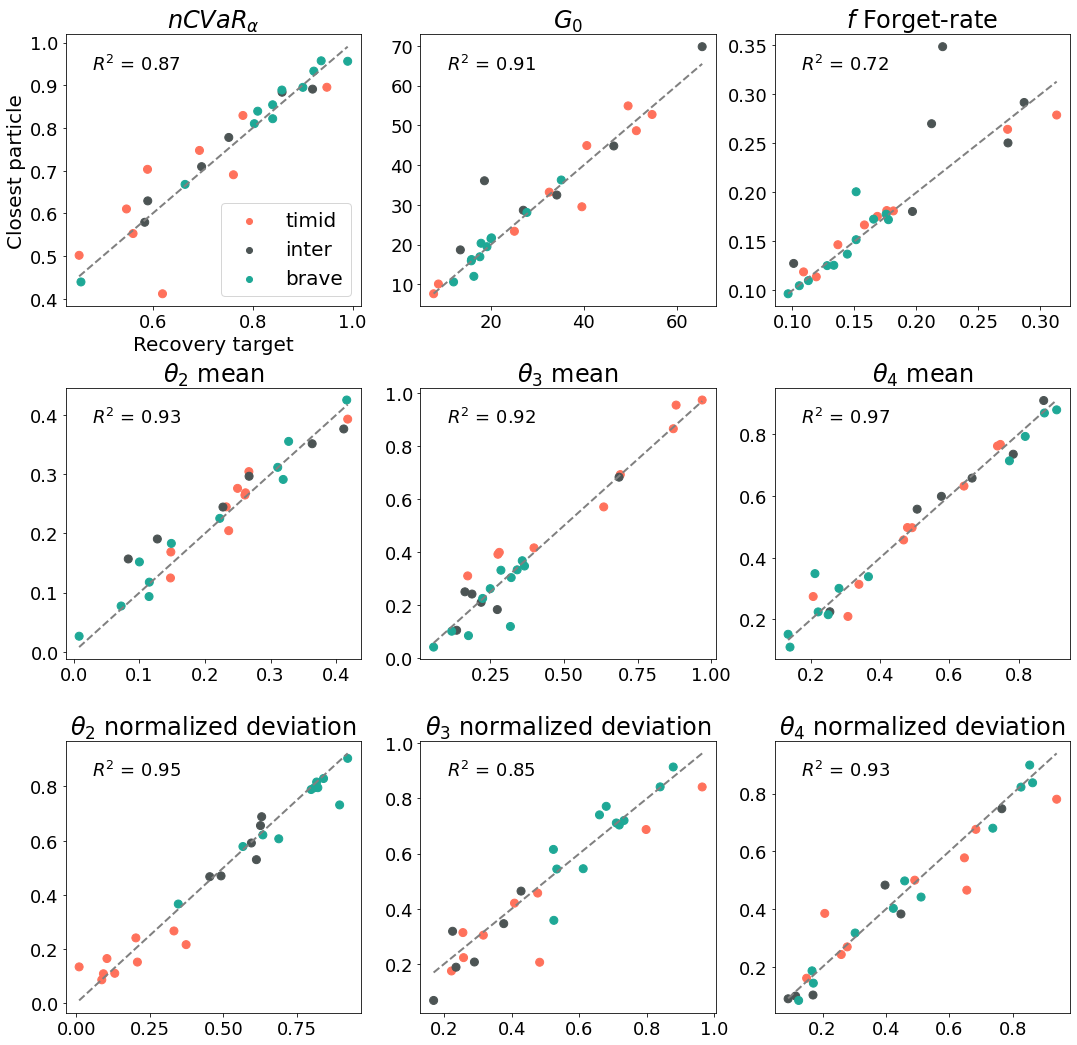

In [60]:
plot_gt_fit_each_dim(gt_values, theta_close_values, ylabel="Closest particle")

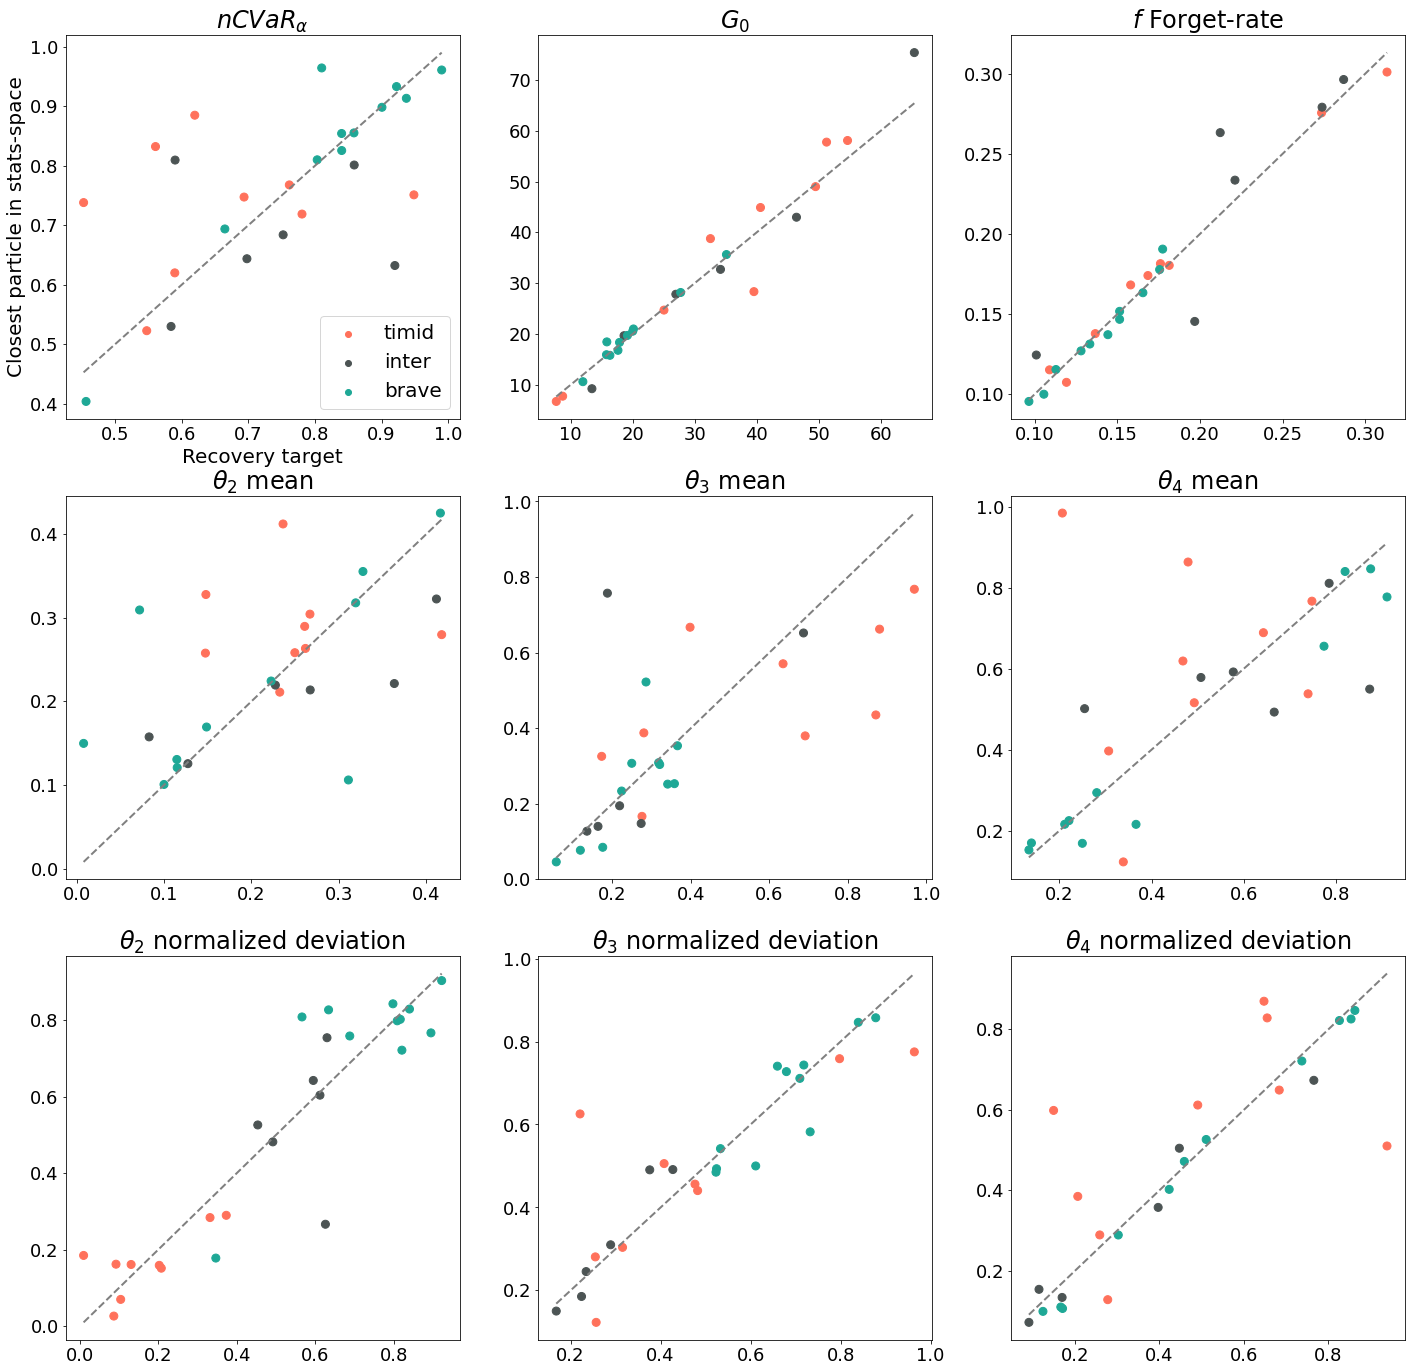

In [126]:
plot_gt_fit_each_dim(gt_values, x_close_values, ylabel="Closest particle in stats-space")